# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
!pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [236]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

# Loading Data

In [225]:
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv('ratings.csv', sep=',', encoding='utf-8')
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [226]:
events_df = pd.read_csv("events.csv")

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [227]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      998 non-null    int64
 1   user_rating  998 non-null    int64
 2   event_id     998 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [228]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,420,5,104
1,985,3,395
2,13,3,302


In [229]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"['Tradeshow', 'Auto & Automotive', 'Rubber & T...",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine – GET your ultimate business chances ...,"['Tradeshow', 'Building & Construction']",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"['Conference', 'Medical & Pharma', 'Investment']",35


In [230]:
combined_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')

In [231]:
ratings = tf.data.Dataset.from_tensor_slices(dict(combined_df)).map(lambda x: {
    "event_name": x["event_name"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})
events = tf.data.Dataset.from_tensor_slices(dict(combined_df)).map(lambda x: x["event_name"])

In [232]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))

In [233]:
event_names = events.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_event_ids = np.unique(np.concatenate(list(event_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Creating Models

## Retrieval Model

In [234]:
embedding_dimension = 32
# Add an additional embedding to account for unknown tokens.
# Candidate tower
event_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_event_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
])

# Query tower
user_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

class RetrievalModel(tfrs.Model):

  def __init__(self):
    super().__init__()
    self.event_model: tf.keras.Model = event_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates=events.batch(128).map(event_model)
        ))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_event_embeddings = self.event_model(features["event_name"])

    # parameter: query embedding, candidate embedding.
    return self.task(user_embeddings, positive_event_embeddings)

## Ranking Model

In [235]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.user_embeddings = user_model
    self.event_embeddings = event_model

    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):
    user_id, event_id = inputs

    user_embedding = self.user_embeddings(user_id)
    event_embedding = self.event_embeddings(event_id)

    # given user and event, predict rating that the user would give to the event
    return self.ratings(tf.concat([user_embedding, event_embedding], axis=1))

class EventModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  # Call what model to use when making prediction
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["event_name"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [14]:
# user id + event id = predicted rating
user_ids, event_ids = np.array([99 for i in range(1000)]), np.array([random.choice(list(combined_df['event_name'])) for i in range(1000)])
predicted_list = list(np.concatenate(RankingModel()((user_ids, event_ids)).numpy()))
predicted_event_id = predicted_list.index(max(predicted_list))
print(f'predicted event id: {predicted_event_id}')
print(f'highest score: {max(predicted_list)}')

predicted event id: 385
highest score: 0.026795217767357826


# Model Fitting, Evaluating, Predicting

## Retrieval Model

### Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [ ]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

retrieval_model.fit(cached_train, epochs=10)

In [262]:
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 327ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0050 - factorized_top_k/top_50_categorical_accuracy: 0.0503 - factorized_top_k/top_100_categorical_accuracy: 0.0854 - loss: 1670.3237 - regularization_loss: 0.0000e+00 - total_loss: 1670.3237


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.005025125574320555,
 'factorized_top_k/top_50_categorical_accuracy': 0.05025125667452812,
 'factorized_top_k/top_100_categorical_accuracy': 0.08542713522911072,
 'loss': 1670.32373046875,
 'regularization_loss': 0,
 'total_loss': 1670.32373046875}

Why test performance is bad:
- The model is re-recommending some events that the users' already rated. These can crowd out test movies out of top K recommendations.
    - In some cases, re-recommending past things is good.

### Making predictions

Now that we have a retrieval_model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [101]:
user_id = random.choice(combined_df['user_id'])
combined_df.loc[combined_df['user_id']==user_id]

,user_id,user_rating,event_id,id,date,event_name,location,description,tags,interested
261,508,2,282,282,"Mon, 24 - Wed, 26 Jul 2023",Mergers & Acquisitions Masterclass (M&A),Jakarta,The Course will provide participants with a st...,"['Conference', 'Education & Training', 'Bankin...",27
415,508,3,355,355,"Fri, 27 - Sat, 28 Oct 2023",International Conference on Biological Science...,Yogyakarta,International Conference on Biological Science...,"['Conference', 'Science & Research']",10
471,508,3,280,280,"Tue, 18 Jul 2023","ICBEM1: International Conference on Business, ...",Palembang,nan,"['Conference', 'Education & Training', 'Econom...",0


In [237]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=10)
# recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_model)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
i, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

Recommendations for user 360: ["b'Indonesia AgroFood Expo (AFE Indonesia)'", "b'Indonesia AgroFood Expo (AFE Indonesia)'", "b'Indonesia AgroFood Expo (AFE Indonesia)'", "b'Indonesia AgroFood Expo (AFE Indonesia)'", "b'International Conference on Science & Technology Research (ICSTR)'", "b'International Conference on Science & Technology Research (ICSTR)'", "b'The ICoGEE : The International Conference on Green Energy and Environment'", "b'The ICoGEE : The International Conference on Green Energy and Environment'", "b'IEOM Annual International Conference'", "b'IEOM Annual International Conference'"]


## Ranking Model

In [238]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

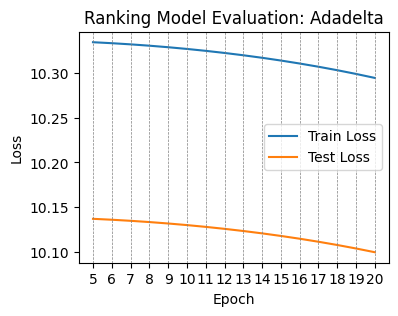

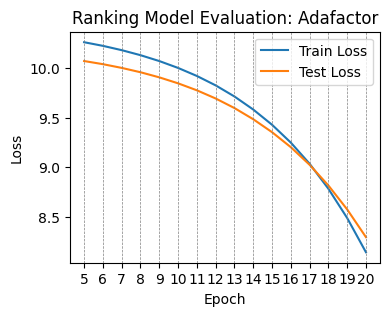

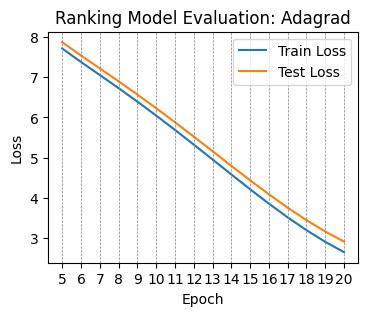

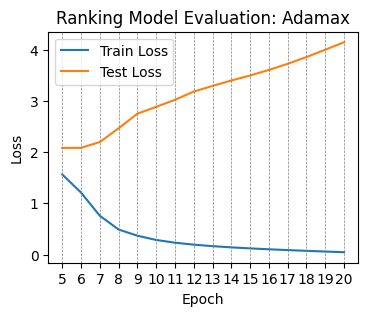

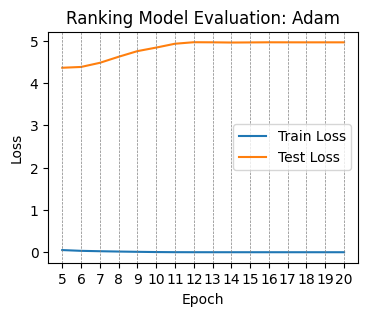

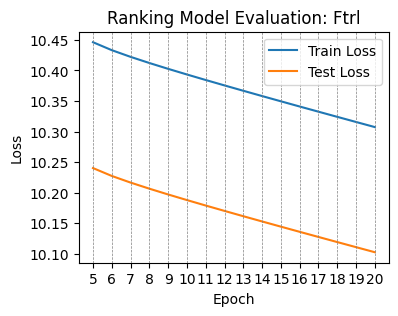

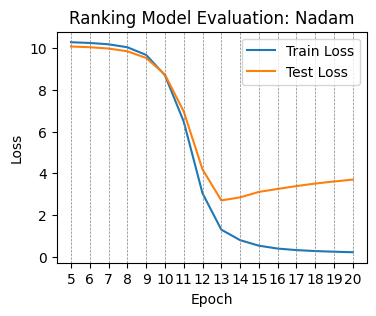

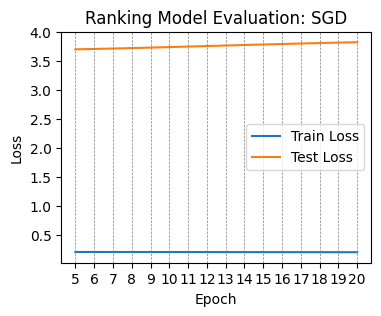

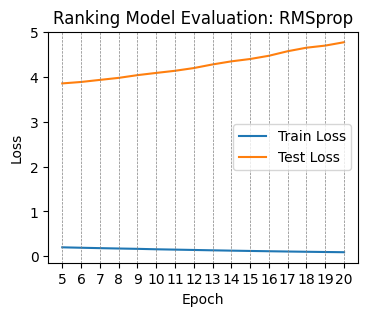

In [105]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adadelta(),
        tf.keras.optimizers.Adafactor(),
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Adamax(),
        tf.keras.optimizers.Adam(),
        tf.keras.optimizers.Ftrl(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD(),
        tf.keras.optimizers.RMSprop(),
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(4,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 5  # Specify the minimum epoch
max_epoch = 20  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


### Choose fitting epoch number

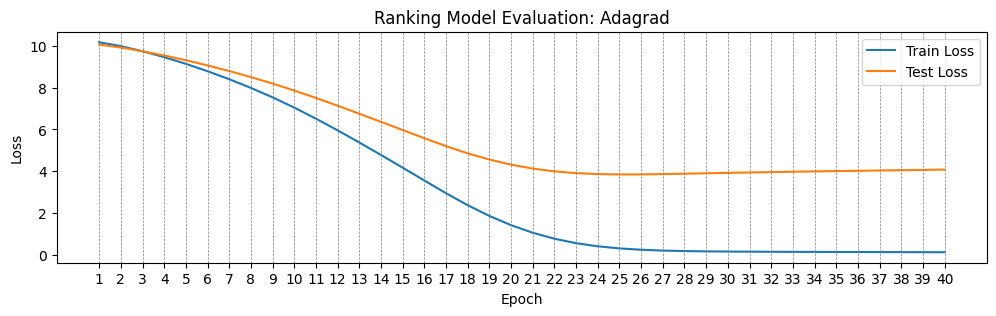

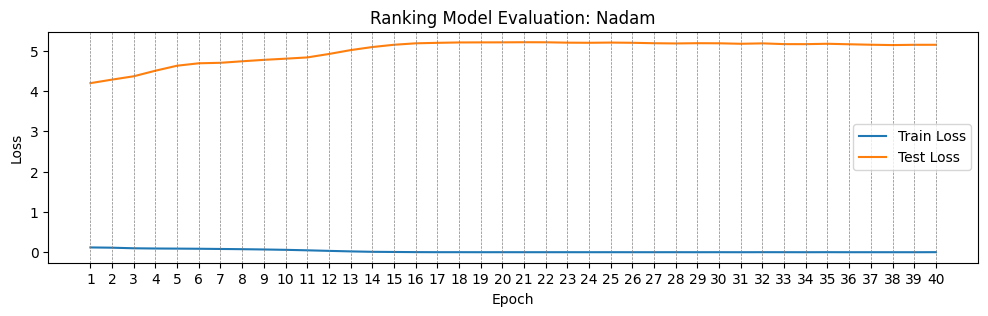

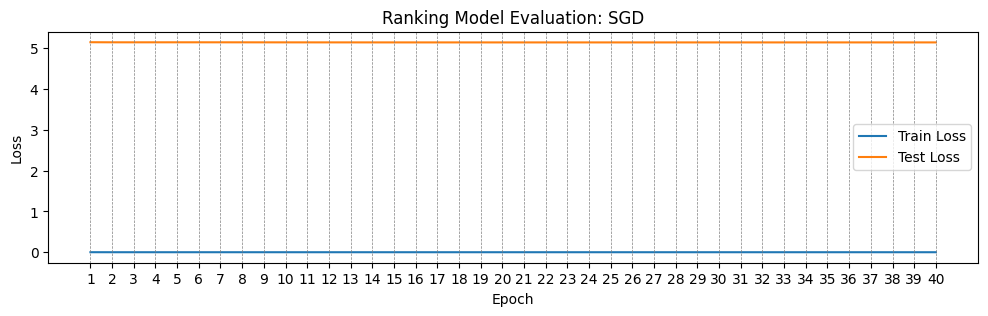

In [106]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD()
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 40  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


### Choose learning rate

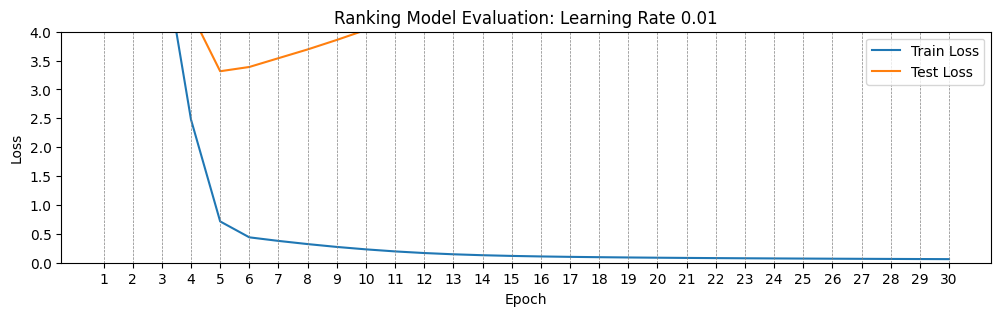

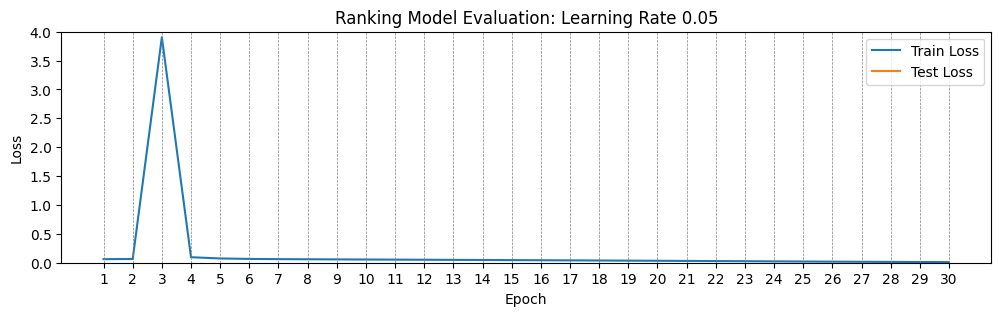

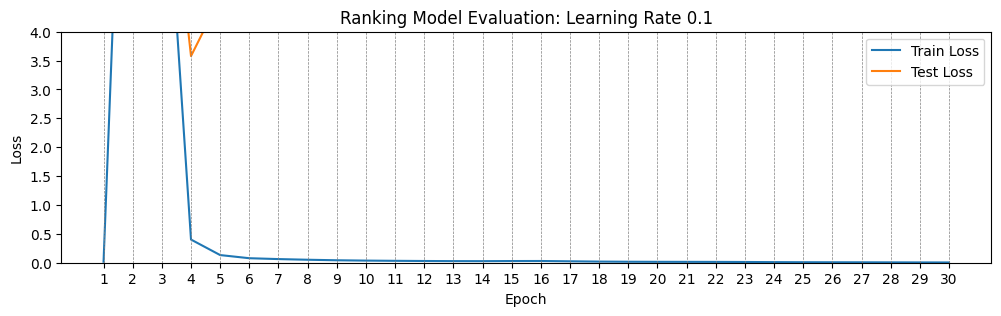

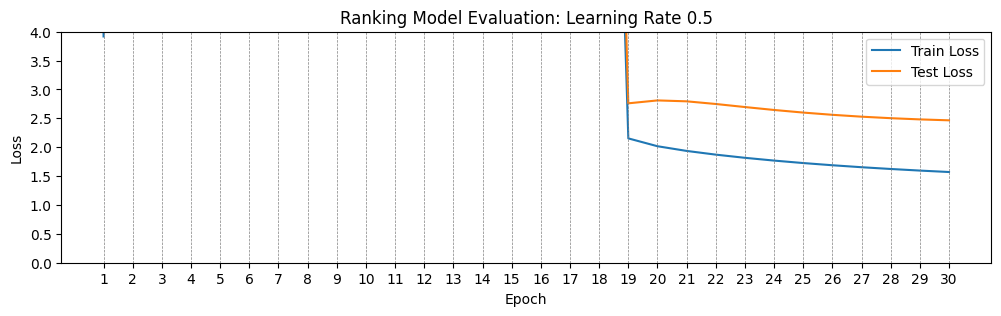

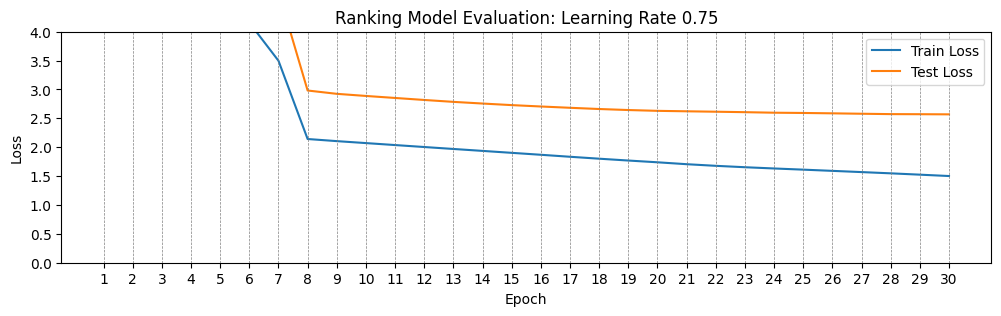

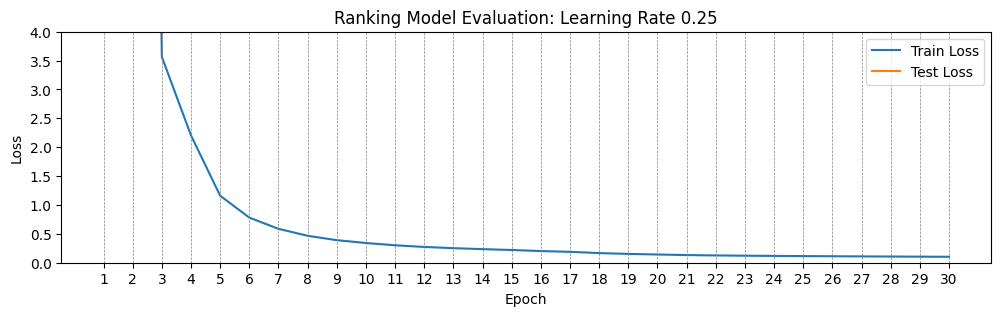

In [107]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    learning_rates = [0.01,0.05,0.1,0.5,0.75,0.25]
    for learning_rate in learning_rates:
        train_losses = []
        test_losses = []
        model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: Learning Rate {learning_rate}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.ylim(bottom=0, top=4)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 30  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


# Choose Epoch for chosen learning rate

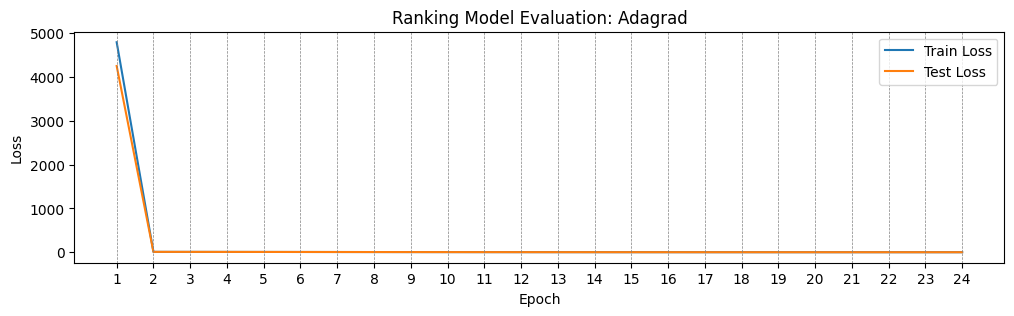

In [135]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adagrad(learning_rate=0.75)
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 24  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


In [239]:
for _ in range(10):
    ranking_model = EventModel()
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.75))
    ranking_model.fit(cached_train, epochs=4, verbose=0)
    print(ranking_model.evaluate(cached_test, return_dict=True))

1/1 [==============================] - 0s 94ms/step - root_mean_squared_error: 14.1285 - loss: 199.6153 - regularization_loss: 0.0000e+00 - total_loss: 199.6153
{'root_mean_squared_error': 14.12852954864502, 'loss': 199.61534118652344, 'regularization_loss': 0, 'total_loss': 199.61534118652344}
1/1 [==============================] - 0s 74ms/step - root_mean_squared_error: 72.1511 - loss: 5205.7832 - regularization_loss: 0.0000e+00 - total_loss: 5205.7832
{'root_mean_squared_error': 72.15111541748047, 'loss': 5205.783203125, 'regularization_loss': 0, 'total_loss': 5205.783203125}
1/1 [==============================] - 0s 75ms/step - root_mean_squared_error: 426.6611 - loss: 182039.6719 - regularization_loss: 0.0000e+00 - total_loss: 182039.6719
{'root_mean_squared_error': 426.66107177734375, 'loss': 182039.671875, 'regularization_loss': 0, 'total_loss': 182039.671875}


1/1 [==============================] - 0s 74ms/step - root_mean_squared_error: 3.2543 - loss: 10.5905 - regularization_loss: 0.0000e+00 - total_loss: 10.5905
{'root_mean_squared_error': 3.2543041706085205, 'loss': 10.590495109558105, 'regularization_loss': 0, 'total_loss': 10.590495109558105}


1/1 [==============================] - 0s 73ms/step - root_mean_squared_error: 153.9326 - loss: 23695.2480 - regularization_loss: 0.0000e+00 - total_loss: 23695.2480
{'root_mean_squared_error': 153.93260192871094, 'loss': 23695.248046875, 'regularization_loss': 0, 'total_loss': 23695.248046875}
1/1 [==============================] - 0s 72ms/step - root_mean_squared_error: 2.9263 - loss: 8.5633 - regularization_loss: 0.0000e+00 - total_loss: 8.5633
{'root_mean_squared_error': 2.926316976547241, 'loss': 8.563331604003906, 'regularization_loss': 0, 'total_loss': 8.563331604003906}
1/1 [==============================] - 0s 71ms/step - root_mean_squared_error: 187.9172 - loss: 35312.8633 - regularization_loss: 0.0000e+00 - total_loss: 35312.8633
{'root_mean_squared_error': 187.91717529296875, 'loss': 35312.86328125, 'regularization_loss': 0, 'total_loss': 35312.86328125}
1/1 [==============================] - 0s 80ms/step - root_mean_squared_error: 432.0560 - loss: 186672.3594 - regularizat

# Finalize model

In [240]:
ranking_model = EventModel()
ranking_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05))
ranking_model.fit(cached_train, epochs=4, verbose=0)

In [241]:
import itertools

test_ratings = {}
test_event_ids = [random.choice(list(combined_df['event_name'])) for i in range(1000)]
for event_id in test_event_ids:
  test_ratings[event_id] = ranking_model({
      "user_id": np.array([33]),
      "event_name": np.array([event_id])
  })

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x, reverse=True),10):
  title = id
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x),10):
  title = id
  print(f"{title}: {score[0][0]}")

Ratings Desc:
rnational Conference on Signal Processing and Intelligent Systems: 3.294821262359619
iMedia Online Retail Summit South East Asia: 3.361909866333008
Zak World of Facades South East Asia: 3.4682798385620117
Yogyakarta International Seminar on Health, Physical Education, and Sports Science (YISHPESS): 3.598877429962158
X-Ray - Chest Interpretation Essentials: 2.9831933975219727
X-Ray - Chest & Emergency Interpretation Essentials: 3.688021659851074
World Waterfowl Conference: 3.729942798614502
World Financial Innovation Series: 3.5655250549316406
World Conference on Science Engineering and Technology (WCSET): 3.042747974395752
World AI Show - Jakarta (WAIS): 3.706173896789551

Ratings Asc:
ACESR : ASEAN Conference on Engineering and Science Research: 3.441652297973633
ALLPACK INDONESIA: 2.9919629096984863
ALLPRINT INDONESIA: 3.005847454071045
ANZI-Pacific Forum: 3.141921043395996
APAC Family Office Investment Summit: 3.5479378700256348
APOS: 3.592909336090088
ASEAN Innovation

In [252]:
list(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True))

[('International Agricultural Chemicals, Fertilizer & Pesticide Exhibition (INAGRICHEM)',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7615113]], dtype=float32)>),
 ('ICCIM : The Third International Conference of Construction, Infrastructure, and Materials',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7416134]], dtype=float32)>),
 ('ICAS : The International Conference on Applied Science',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7361226]], dtype=float32)>),
 ('International Conference on Automation and Electrical Engineering (ICAEE)',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7250457]], dtype=float32)>),
 ('Manufacturing Indonesia',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7219505]], dtype=float32)>),
 ('Indo Fashion Textile & Apparel Expo',
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7156286]], dtype=float32)>),
 ('International Conference on Science in Information Technology (ICSITech)',


# Model Serving

## Retrieval Model

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [242]:
user_id = random.choice(combined_df['user_id'])
combined_df.loc[combined_df['user_id']==user_id]

,user_id,user_rating,event_id,id,date,event_name,location,description,tags,interested
84,597,1,10,10,"Tue, 23 - Wed, 24 May 2023",International Conference on Modern Research in...,Kuta,nan,"['Conference', 'Science & Research', 'Educatio...",40
117,597,3,211,211,"Sat, 25 - Sun, 26 Nov 2023",International Conference on Process & Project ...,Bali,nan,"['Conference', 'Science & Research', 'IT & Tec...",7
194,597,1,39,39,"Wed, 23 - Fri, 25 Aug 2023","International Agricultural Chemicals, Fertiliz...",Jakarta,"The International Agricultural Chemicals, Fert...","['Tradeshow', 'Chemicals & Dyes', 'Agriculture...",182
253,597,2,206,206,"Wed, 26 - Thu, 27 Jul 2023",CyberSec Indonesia Conference,Jakarta,nan,"['Conference', 'IT & Technology', 'Investment']",1
625,597,1,113,113,"Wed, 28 - Thu, 29 Jun 2023",International Multi-Topic Conference on Engine...,Cempaka Putih,nan,"['Conference', 'Science & Research']",4
996,597,4,40,40,"Thu, 29 - Fri, 30 Jun 2023",International Conference on Artificial Intelli...,Jakarta,The Academics World 1468th International Confe...,"['Conference', 'IT & Technology', 'Artificial ...",20


In [243]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
scores, titles = loaded([user_id])

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


## Ranking Model

In [265]:
import itertools

path = "./ranking_model"
tf.saved_model.save(ranking_model, path)
loaded = tf.saved_model.load(path)

test_ratings = {}
test_event_ids = [random.choice(list(combined_df['event_name'])) for i in range(1000)]
for event_id in test_event_ids:
    test_ratings[event_id] = loaded(
        {'user_id':tf.constant([user_id], dtype=tf.int64),
        'event_name':tf.constant([event_id], dtype=tf.string)}
    )
test_ratings

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


{'rnational Conference on Signal Processing and Intelligent Systems': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.5083222]], dtype=float32)>,
 'Batik Bordir & Accessories Fair': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.14629]], dtype=float32)>,
 'International Joint Conference on Natural Language Processing and the Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics...': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.7573195]], dtype=float32)>,
 'Taiwan Innotech Expo': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.3812437]], dtype=float32)>,
 'Paper Indonesia': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.671327]], dtype=float32)>,
 'Indonesia International Pet Expo (IIPE)': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.871108]], dtype=float32)>,
 'International Conference on Contemporary Issues in Science, Engineering and Technology (ICCISET)': <tf.Tensor: shape=(1, 1), dtype=f

In [266]:
loaded.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, user_id, event_name) at 0x1A3B6BEA210>})